# Twitter NLP Sentiment Classifier

This notebook builds a simple NLP model to classify tweets as positive, neutral, or negative using the [Twitter140 dataset](https://www.kaggle.com/datasets/kazanova/sentiment140)



In [137]:
#import basic core libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---
### 1. Data Preprocessing 🔨

#### Steps 📄:
- Load and inspect Sentiment140 dataset

- Split into training, validation, and testing sets

We'll begin by loading our dataframe and exploring the dataset to get an understanding of its structure and the distribution of sentiment labels.

In [138]:
df = pd.read_csv("../data/Sentiment140.csv", encoding="latin-1", header=None)

print(df.head())
df[0].value_counts()

   0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


0
0    800000
4    800000
Name: count, dtype: int64

We are only going to be using the sentiment and text, which are found in column 1 and 5 respectively.<br/>
The sentiment is distributed evenly between 0 (negative) and 4 (positive).<br/>

Lets label our columns and grab the ones we want. <br/>
We'll also map all 4s to 1 for binary simplicity.

In [139]:
df.columns = ["sentiment", "id", "date", "flag", "user", "text"]
df = df[["sentiment", "text"]]

df["sentiment"] = df["sentiment"].replace({4:1})

print(df.head())
print(df["sentiment"].value_counts())

   sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....
sentiment
0    800000
1    800000
Name: count, dtype: int64


Now we can split the data into train, validation, and test using stratified sampling to ensure fair evaluation.

In [ ]:
from sklearn.model_selection import train_test_split

print (df["sentiment"].value_counts())
df = df.drop_duplicates(subset="text")
print (df["sentiment"].value_counts())

# Split into train&val (90%) and the test set (10%)
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(df["text"].values, df["sentiment"].values, test_size=0.1, random_state=1)

# Now split train&val into train (90% of 90% --> 81%) and val (10% of 90% --> 9%)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_val_texts, train_val_labels, test_size=0.2, random_state=1)

print(f"train split: {train_texts.shape[0]}")
print(f"validation split: {val_texts.shape[0]}")
print(f"test split: {test_texts.shape[0]}")

sentiment
0    800000
1    800000
Name: count, dtype: int64
sentiment
1    791281
0    790185
Name: count, dtype: int64
train split: 1138655
validation split: 284664
test split: 158147


We will vectorize text at the beginning of our ML approach and tokenize at the start of our DL approach.

---
### 2. Classical ML Approach 💻

#### Steps 📄:
- Extract features with TF-IDF

- Train logistic regression model

- Evaluate model on validation and test set

- Analyze performance

We will start our ML approach by vectorizing our text data and fitting our model to the train data.

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=15000)

# These will be the features for our ML model, we fit on our training features
ml_X_train = vectorizer.fit_transform(train_texts)
ml_X_val = vectorizer.transform(val_texts)
ml_X_test = vectorizer.transform(test_texts)

# The labels for our ML model
ml_y_train = train_labels
ml_y_val = val_labels
ml_y_test = test_labels

Now we can take a look at the first 10 words inside the internal feature matrix and their respective IDF scores.

In [142]:
print (f"First 10 words: {list(vectorizer.vocabulary_.keys())[:10]}")
print (f"IDF Scores: {vectorizer.idf_[:10]}")

First 10 words: ['snuggled', 'in', 'on', 'the', 'couch', 'with', 'got', 'player', 'so', 'finally']
IDF Scores: [ 8.25079712  8.47301288 10.3603917  10.50270792 10.41275968 10.26322795
 10.50270792  9.90840658  9.95492659  9.5887729 ]


Next we'll initialize and train a logistic regression model on our data.

In [143]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(ml_X_train, ml_y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Now lets get a baseline to see how our model performs on its training data.

In [144]:
from sklearn.metrics import accuracy_score

ml_train_preds = clf.predict(ml_X_train)

print (f"Training Accuracy: {accuracy_score(ml_y_train, ml_train_preds)}")

Training Accuracy: 0.8026557649156242


Our training accuracy is good, 75-80% is a nice range to fall in for this model on this dataset. We're just going to be using this model as a baseline to compare against our DL model so we don't necessarily need to fine tune the hyperparameters (unless we see an issue). Before we evaluate on our test set, though, lets check our validation accuracy to make sure the model isn't overfitting.

In [145]:
from sklearn.metrics import classification_report

ml_val_preds = clf.predict(ml_X_val)

print (f"Validation Accuracy: {accuracy_score(ml_y_val, ml_val_preds)}")
print (classification_report(ml_y_val, ml_val_preds))

Validation Accuracy: 0.7956011297529719
              precision    recall  f1-score   support

           0       0.80      0.78      0.79    142442
           1       0.79      0.81      0.80    142222

    accuracy                           0.80    284664
   macro avg       0.80      0.80      0.80    284664
weighted avg       0.80      0.80      0.80    284664



Nice, it looks like the model isn't overfitting and is doing well at generalizing to our validation set.

Now lets evaluate the model's performance on the test set.

In [146]:
ml_test_preds = clf.predict(ml_X_test)

print (f"Test Accuracy: {accuracy_score(ml_y_test, ml_test_preds)}")
print (classification_report(ml_y_test, ml_test_preds))

Test Accuracy: 0.7970116410681202
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     79036
           1       0.79      0.81      0.80     79111

    accuracy                           0.80    158147
   macro avg       0.80      0.80      0.80    158147
weighted avg       0.80      0.80      0.80    158147



Great, around 79% accuracy is a nice baseline to compare to moving fowards. Now we can move to our DL approach.

---
### 3. Deep Learning Approach 🧠

#### Steps 📄:
- Tokenize and vectorize features

- Create dataset and dataloaders

- Build and train LSTM model

- Test on validation and test sets

Lets start by building our vocabulary which includes tokenization and numericalization.

In [147]:
import torch
from collections import Counter

class Vocabulary:
    def __init__(self, min_freq=5):
        self.min_freq = min_freq
        self.word2idx = {"<pad>": 0, "<unk>": 1}
        self.idx2word = {0: "<pad>", 1: "<unk>"}
        self.idx = 2
    
    # Build vocabulary, updating word2idx and idx2word with words that appear >= min_freq
    def build_vocab(self, tweets):
        counter = Counter()
        for tweet in tweets:
            counter.update(tweet.lower().split())

        for word, count in counter.items():
            if count>= self.min_freq and word not in self.word2idx:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx+= 1
    
    # Convert a given tweet to indexes
    def numericalize(self, tweet):
        tokens = tweet.lower().split()
        return [self.word2idx.get(token, self.word2idx["<unk>"]) for token in tokens]

# Build vocab
vocab = Vocabulary()
#vocab.build_vocab(df_train["text"])


vocab.build_vocab(train_texts)

# Check
print (f"Vocab size: {len(vocab.word2idx)}")
print (f"First 3 words: {vocab.idx2word[2]}, {vocab.idx2word[3]}, {vocab.idx2word[4]}")

Vocab size: 92569
First 3 words: snuggled, in, on


Great, now lets create our `Dataset` class.

In [148]:
from torch.utils.data import Dataset

# PyTorch Dataset for our DataLoaders
class TweetDataset(Dataset):
    def __init__(self, tweets, sentiments, vocab, max_len=100):
        self.tweets = tweets
        self.sentiments = sentiments
        self.vocab = vocab
        self.max_len = max_len
        
    def __len__(self):
        return len(self.tweets)
    
    # Convert to numerical tokens and return feature and label as tensor pair
    def __getitem__(self, index):
        text = self.tweets[index]
        label = self.sentiments[index]

        # Convert text to numericalized tokens
        numericalized = self.vocab.numericalize(text)
        
        return (
            torch.tensor(numericalized, dtype=torch.long),
            torch.tensor(label, dtype=torch.float)
        )

Next lets make the collate function for our DataLoaders to pad our texts and batch our features and labels

In [149]:
from torch.nn.utils.rnn import pad_sequence

def collate(batch):
    texts, labels = zip(*batch)

    # pads tweets to same length and returns as a stacked tensor (batch size, longest tweet)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)

    # stacks labels into tensor
    labels = torch.stack(labels)

    return padded_texts, labels

Now lets make the `DataLoaders` for our model.

In [150]:
from torch.utils.data import DataLoader

max_len = 100
batch_size = 64


# Creates datasets
test_dataset = TweetDataset(test_texts.tolist(), test_labels.tolist(), vocab, max_len)
train_dataset = TweetDataset(train_texts.tolist(), train_labels.tolist(), vocab, max_len)
val_dataset = TweetDataset(val_texts.tolist(), val_labels.tolist(), vocab, max_len)
    
# Wraps datasets in DataLoaders and shuffles training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)

Before we move to building the model, lets verify our data.

In [151]:
# Check our dataset lengths
print (f"Training samples: {len(train_dataset)}")
print (f"Validation samples: {len(val_dataset)}")
print (f"Test samples: {len(test_dataset)}")

# Check the first training sample
text, sentiment = train_dataset[0]
print (f"Raw sample text: {train_texts[0]}")
print (f"Processed sample text: {text}")
print (f"Sample label: {sentiment}")

# Check batch shapes
batch_texts, batch_sentiments = next(iter(train_loader))
print (f"Texts tensor shape: {batch_texts.shape}")
print (f"Labels tensor shape: {batch_sentiments.shape}")

#Check batch content
first_text = [vocab.idx2word[i] for i in (batch_texts[0].tolist()) if i != vocab.word2idx["<pad>"]]
print (f"First text in batch: {' '.join(first_text)}")
print (f"First label in batch: {batch_sentiments[0].item()}")

Training samples: 1138655
Validation samples: 284664
Test samples: 158147
Raw sample text: Snuggled in on the couch with Dex.. I got a divex player so I'm finally watching season 1 of True Blood @wallybertone sent me   xox
Processed sample text: tensor([ 2,  3,  4,  5,  6,  7,  1,  8,  9, 10,  1, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20,  1, 21, 22, 23])
Sample label: 1.0
Texts tensor shape: torch.Size([64, 29])
Labels tensor shape: torch.Size([64])
First text in batch: just got home from school, done my science exam, gonna catch up on some <unk> didn't sleep well last night
First label in batch: 0.0


Great, our datasets look good and our DataLoaders appear to be working. <br/>
Feature tensors are the right shape (labels as well) and padding looks to be working.

Now lets move foward with making our LSTM model.

In [152]:
import torch.nn as nn
      
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_index, dropout_rate):
        super().__init__()
        # Embedding layer: converts tweets (stored as vocab indexes) to dense embedded vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim, pad_index)
        nn.init.uniform_(self.embedding.weight, -0.05, 0.05)
        # LSTM layer: processes embedded input, learning sequential patterns
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Dropout layer: drops out percentage of neurons for regularization
        self.dropout = nn.Dropout(dropout_rate)
        # Fully connected layer: takes final hidden state from LSTM and converts to output classes
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        
        last_state = self.dropout(lstm_out[:, -1, :])
        return self.fc(last_state)

With our layers and forward pass defined, lets move on to defining our hyperparameters.

In [153]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifier(
    vocab_size=len(vocab.word2idx),
    embedding_dim = 100,
    hidden_dim = 128,
    output_dim = 1,
    pad_index = 0,
    dropout_rate = 0.5
).to(device)

# We are using BCE for our loss function to classify our logits from the FC layer w/ softmax 
# Adam is a good, simple optimizer for NLP tasks, especially when using LSTMs like this model
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

With our model defined, lets build the training loop.

In [154]:
def train_loop(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    batches = len(iterator)
    model.train()
    
    for batch_idx, batch in enumerate(iterator):
        optimizer.zero_grad()
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        
        # Calculate accuracy
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == labels).float()
        acc = correct.sum() / len(correct)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        print(f"Processing batch {batch_idx + 1}/{batches}", end='\r')
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Next, lets make our evaluation function.

In [155]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            correct = (rounded_preds == labels).float()
            acc = correct.sum() / len(correct)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

To get our best model and prevent overfitting, lets implement a simple early stopping class.

In [156]:
class EarlyStopping:
    def __init__(self, patience=2, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.stop_early = False
        self.min_loss = np.Inf
        self.best_state = None
        
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"Early Stop counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.stop_early = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss improved ({self.min_loss} -> {val_loss})")
        self.best_state = {k: v.clone() for k, v in model.state_dict().items()}
        self.min_loss = val_loss
    

In [157]:
print (torch.__version__)
print (torch.cuda.is_available())

early_stopping = EarlyStopping(patience=1, verbose=False)

for epoch in range(10):
    train_loss, train_acc = train_loop(model, train_loader, optimizer=optimizer, criterion=criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion=criterion)
    print (f"Epoch {epoch+1}: Training Acc = {train_acc:.3f} | Val Acc = {val_acc:.3f} | Training Loss = {train_loss:.3f}| Val Loss = {val_loss:.3f}")
    
    early_stopping(val_loss, model)
    if early_stopping.stop_early:
        print ("Early stopping triggered")
        break

if early_stopping.best_state is not None:
    model.load_state_dict(early_stopping.best_state)

2.0.0+cu118
True
Epoch 1: Training Acc = 0.790 | Val Acc = 0.821 | Training Loss = 0.442| Val Loss = 0.396
Epoch 2: Training Acc = 0.842 | Val Acc = 0.827 | Training Loss = 0.358| Val Loss = 0.386
Epoch 3: Training Acc = 0.865 | Val Acc = 0.823 | Training Loss = 0.315| Val Loss = 0.395
Early stopping triggered


In [158]:
test_loss, test_acc = evaluate(model, test_loader, criterion=criterion)
print (f"Test loss = {test_loss} | Test Acc = {test_acc}")

Test loss = 0.3861074270831246 | Test Acc = 0.8255713996763754


Awesome, ~82% is a great accuracy and it's nice to see our LSTM is doing better than the traditional LR model.

### 4. Comparisons and Conclusions 💭

To compare our two models (ML and DL), lets start by comparing their standard metrics (F1 score, accuracy/loss, ROC curve)

#### F1 score, recall, and precision

In [159]:
# Logistic Regression model
ml_preds = clf.predict(vectorizer.transform(test_texts))

# LSTM model
model.eval()
dl_preds = []

with torch.no_grad():
    for batch in test_loader:
        texts, labels = batch
        texts = texts.to(next(model.parameters()).device)
        output = model(texts)
        
        probs = torch.sigmoid(output).squeeze()
        preds = (probs >= 0.5).int()
        
        dl_preds.extend(preds.cpu().numpy())
dl_preds = np.array(dl_preds)
                        
#Create classification reports
from sklearn.metrics import classification_report

print("ML (LR) Report:\n", classification_report(test_labels, ml_preds))
print("DL (LSTM) Report:\n", classification_report(test_labels, dl_preds))

ML (LR) Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     79036
           1       0.79      0.81      0.80     79111

    accuracy                           0.80    158147
   macro avg       0.80      0.80      0.80    158147
weighted avg       0.80      0.80      0.80    158147

DL (LSTM) Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82     79036
           1       0.82      0.83      0.83     79111

    accuracy                           0.83    158147
   macro avg       0.83      0.83      0.83    158147
weighted avg       0.83      0.83      0.83    158147



Nice! Looks, like both models perform well with the LSTM model performing a little better by about 3%. Furthermore, both perform well across each class and we can again verify our balanced dataset.<br/>
Now lets plot each model's ROC curve along with their AUCs to gain insight into the TPR v.s. FPR across every threshold.

#### ROC Curves

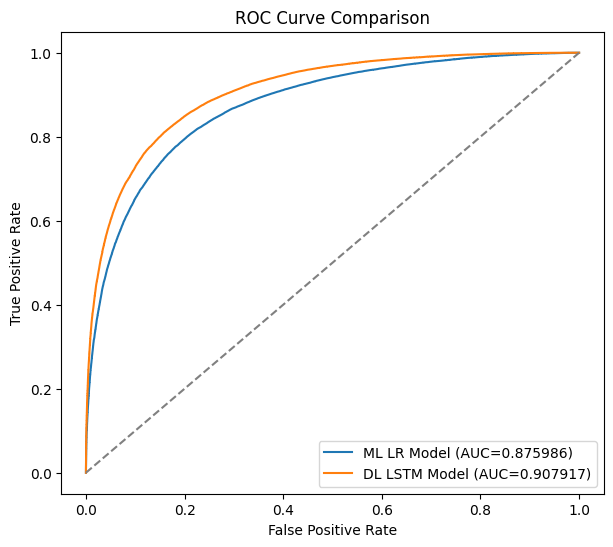

In [161]:
#Logistic Regression model
ml_prob = clf.predict_proba(vectorizer.transform(test_texts))[:, 1]

#LSTM model
model.eval()
dl_probs = []

with torch.no_grad():
    for batch in test_loader:
        texts, labels = batch
        texts = texts.to(next(model.parameters()).device)
        output = model(texts)
        
        probs = torch.sigmoid(output).squeeze()
        
        dl_probs.extend(probs.cpu().numpy())
dl_probs = np.array(dl_probs)

#Create ROC curves
from sklearn.metrics import roc_curve, roc_auc_score

#LR model
ml_fpr, ml_tpr, _ = roc_curve(test_labels, ml_prob)
ml_auc = roc_auc_score(test_labels, ml_prob)

#LSTM model
dl_fpr, dl_tpr, _ = roc_curve(test_labels, dl_probs)
dl_auc = roc_auc_score(test_labels, dl_probs)

#Lets plot them
plt.figure(figsize=(7, 6))

plt.plot(ml_fpr, ml_tpr, label=f"ML LR Model (AUC={ml_auc:3f})")
plt.plot(dl_fpr, dl_tpr, label=f"DL LSTM Model (AUC={dl_auc:3f})")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


Wow, absolutely great performance from both models. Specifically an amazing AUC score from our LSTM model w/ <u>**0.9**</u>!

Now lets further visualize these models' performance at their current thresholds using confusion matrices.

#### Confusion Matrices

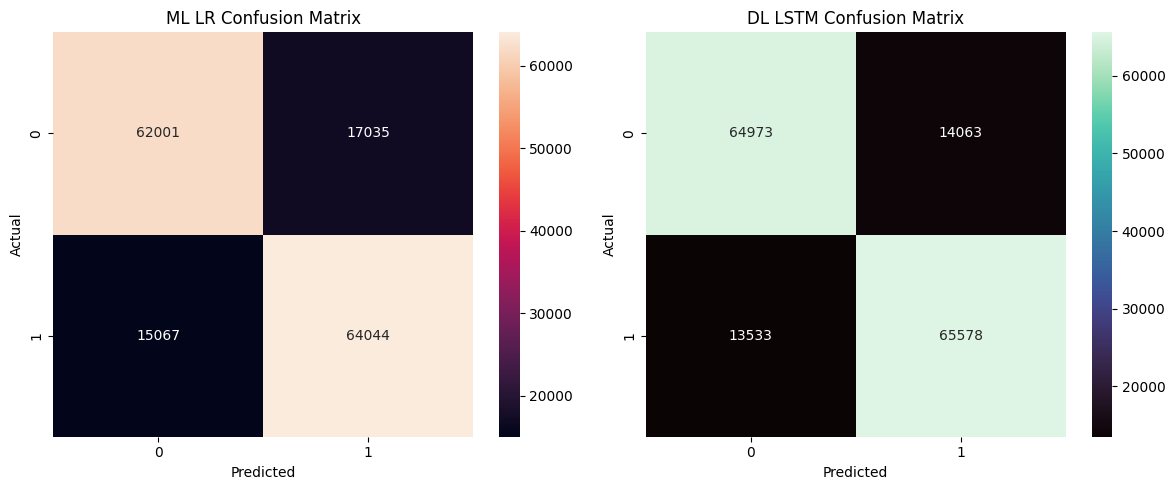

In [170]:
#Just using previous varibles from classification report
from sklearn.metrics import confusion_matrix

ml_cm = confusion_matrix(test_labels, ml_preds)
dl_cm = confusion_matrix(test_labels, dl_preds)

#Lets visualize them
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(ml_cm, annot=True, fmt="d", cmap="rocket", ax=axes[0])
axes[0].set_title("ML LR Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(dl_cm, annot=True, fmt="d", cmap="mako", ax=axes[1])
axes[1].set_title("DL LSTM Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

Nice, this highlights the better performance of the DL model as well as the TPR v.s. FPR between classses.<br/>

Specifically, the ML model appears to struggle a little more with negative sentiment, showing a higher FPR relative to positive tweets. One reason for this could be due to the LSTM's ability to pick up on sentiment and more context-dependend langauge, whereas the TF-IDF LR model is not as complex. <br/>For example, the tweets "This model is <u>not</u> good" and "I <u>don't</u> like this" could become a false positive as the logistic regression model may not pick up on "not" and "don't", instead focusing on "good" and "like".

Now, lets take a look at the models' error overlap to figure out where they're failing (together or seperately).

#### Error Overlap

In [ ]:
#Using vars from earlier
ml_errors = (ml_preds != test_labels)
dl_errors = (dl_preds != test_labels)

overlap = np.logical_and(ml_errors, dl_errors)
just_ml = np.logical_and(ml_errors, ~dl_errors)
just_dl = np.logical_and(~ml_errors, dl_errors)

print("Total test samples:", len(test_labels))
print("Errors ML:", ml_errors.sum())
print("Errors DL:", dl_errors.sum())
print("Error overlap:", overlap.sum())
print("Unique ML errors:", just_ml.sum())
print("Unique DL errors:", just_dl.sum())

Total test samples: 158147
Errors ML: 32102
Errors DL: 27596
Error overlap: 19090
Unique ML errors: 13012
Unique DL errors: 8506


Some nice insights, futher proving the effectiveness of our DL model.<br/>
But, the error overlap doesn't give us the best feel for each model fails on. Instead, lets test on some of our own tweets that we input and see how each model makes a prediction.

In [199]:
#Use the example or replace with text of your choice
tweet_input = "This model is not good"

#LR model
ml_input_pred = clf.predict(vectorizer.transform([tweet_input]))[0]
ml_input_pred = "Positive" if ml_input_pred==1 else "Negative"

#LSTM model
model.eval()

tokenized = []
for word in tweet_input.split():
    if word in vocab.word2idx:
        tokenized.append(vocab.word2idx[word])
    else:
        tokenized.append(vocab.word2idx['<unk>'])
tensorized = torch.tensor(tokenized, dtype=torch.long).unsqueeze(0)
tensorized = tensorized.to(next(model.parameters()).device)

with torch.no_grad():
    output = model(tensorized)
    dl_prob = torch.sigmoid(output).item()
    dl_input_pred = "Postive" if dl_prob >= 0.5 else "Negative"

print(f"ML Prediction: {ml_input_pred}  |  DL Prediction: {dl_input_pred}")

ML Prediction: Positive  |  DL Prediction: Negative


Awesome. That allows us to play around with different user-chosen tweet inputs. If you use the example "This model is <u>not</u> good" you can see for yourself how the ML model struggles to pick up on context-dependent sentiment whereas the DL model succeeds.